In [1]:
import os
import math
import random
import requests
from io import BytesIO
from dataclasses import dataclass
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# --- Imports for models ---
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    CLIPVisionModel, 
    CLIPImageProcessor, 
    WhisperModel, 
    WhisperProcessor
)
from datasets import load_dataset
import librosa

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:


# Set device for adapters (Qwen manages its own device map)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using adapter device: {device}")

# ============================================================
# 1. Configuration
# ============================================================
@dataclass
class Config:
    # Checkpoint path (Ensure this matches where you saved it!)
    ckpt_path: Path = Path("./runs_perceiver_mrl_qwen/multimodal_adapter_poc_1.pt")
    
    # Models
    vision_model_name: str = "openai/clip-vit-base-patch32"
    audio_model_name: str = "openai/whisper-base"
    llm_model_name: str = "Qwen/Qwen2.5-7B-Instruct"
    
    # Architecture Dims (Must match training!)
    perceiver_dim: int = 512
    num_latents: int = 64
    num_perceiver_layers: int = 2
    num_attn_heads: int = 8
    mlp_ratio: float = 4.0
    
    # Filled dynamically later
    encoder_dim_vision: int = 768 
    encoder_dim_audio: int = 512 
    llm_hidden_size: int = 3584
    
    # Data for Eval
    batch_size: int = 8
    vision_max_samples: int = 100  # Small subset for fast eval
    audio_max_samples: int = 100
    seed: int = 42

cfg = Config()


Using adapter device: cuda


In [3]:

# ============================================================
# 2. Architecture Definitions (Must match training code)
# ============================================================

class ModalityAdapter(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.proj = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        return self.proj(x)

class FeedForward(nn.Module):
    def __init__(self, dim: int, mlp_ratio: float = 4.0):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x): 
        return self.net(x)

class PerceiverLayer(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float = 4.0):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.self_attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.ln_latents_1 = nn.LayerNorm(dim)
        self.ln_tokens = nn.LayerNorm(dim)
        self.ln_latents_2 = nn.LayerNorm(dim)
        self.ln_latents_3 = nn.LayerNorm(dim)
        self.mlp = FeedForward(dim, mlp_ratio)

    def forward(self, latents, tokens, token_mask=None):
        # Cross-Attention
        q = self.ln_latents_1(latents)
        kv = self.ln_tokens(tokens)
        # Create key_padding_mask (True for ignored positions)
        key_padding_mask = ~token_mask.bool() if token_mask is not None else None
        
        attn_out, _ = self.cross_attn(q, kv, kv, key_padding_mask=key_padding_mask, need_weights=False)
        latents = latents + attn_out
        
        # Self-Attention
        q2 = self.ln_latents_2(latents)
        self_out, _ = self.self_attn(q2, q2, q2, need_weights=False)
        latents = latents + self_out
        
        # MLP
        latents = latents + self.mlp(self.ln_latents_3(latents))
        return latents

class PerceiverResampler(nn.Module):
    def __init__(self, dim, num_latents, num_layers, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.latents = nn.Parameter(torch.randn(num_latents, dim) / math.sqrt(dim))
        self.layers = nn.ModuleList([
            PerceiverLayer(dim, num_heads, mlp_ratio) for _ in range(num_layers)
        ])

    def forward(self, tokens, token_mask=None):
        B = tokens.shape[0]
        latents = self.latents.unsqueeze(0).expand(B, -1, -1)
        for layer in self.layers:
            latents = layer(latents, tokens, token_mask)
        return latents


In [4]:

# ============================================================
# 3. The Aligned Model Wrapper (Fixed for Device Map)
# ============================================================

class AlignedModel(nn.Module):
    def __init__(self, vision_adapter, audio_adapter, perceiver, projector, qwen_model, qwen_tokenizer):
        super().__init__()
        self.vision_adapter = vision_adapter
        self.audio_adapter = audio_adapter
        self.perceiver = perceiver
        self.projector = projector
        self.qwen_model = qwen_model
        self.qwen_tokenizer = qwen_tokenizer

    def encode_image_features(self, features, mask):
        # Move inputs to the same device as the adapter (which is on 'device')
        adapter_dev = next(self.vision_adapter.parameters()).device
        features = features.to(adapter_dev)
        mask = mask.to(adapter_dev)
        
        tokens = self.vision_adapter(features)
        latents = self.perceiver(tokens, mask)
        z_llm = self.projector(latents)
        return z_llm.mean(dim=1) # Pooling for retrieval

    def encode_audio_features(self, features, mask):
        adapter_dev = next(self.audio_adapter.parameters()).device
        features = features.to(adapter_dev)
        mask = mask.to(adapter_dev)
        
        tokens = self.audio_adapter(features)
        latents = self.perceiver(tokens, mask)
        z_llm = self.projector(latents)
        return z_llm.mean(dim=1)

    def encode_text_raw(self, texts: list[str]):
        # Find Qwen's device for embeddings
        qwen_dev = self.qwen_model.model.embed_tokens.weight.device
        
        enc = self.qwen_tokenizer(
            texts, padding=True, truncation=True, max_length=64, return_tensors="pt"
        ).to(qwen_dev)
        
        with torch.no_grad():
            token_embs = self.qwen_model.get_input_embeddings()(enc.input_ids)
            
        mask = enc.attention_mask.unsqueeze(-1)
        sum_embs = (token_embs * mask).sum(dim=1)
        count = mask.sum(dim=1).clamp(min=1)
        return sum_embs / count

    @torch.no_grad()
    def generate(self, modality_feats, modality_type, prompt_text, max_new_tokens=50):
        """
        Generates text from an image or audio feature input.
        """
        # 1. Project Modality (on adapter device)
        if modality_type == "vision":
            adapter = self.vision_adapter
        elif modality_type == "audio":
            adapter = self.audio_adapter
            
        adapter_dev = next(adapter.parameters()).device
        modality_feats = modality_feats.to(adapter_dev)
        
        # Create mask (B=1)
        mask = torch.ones(1, modality_feats.shape[1], dtype=torch.bool, device=adapter_dev)
        
        tokens = adapter(modality_feats)
        latents = self.perceiver(tokens, mask)
        inputs_embeds_modality = self.projector(latents) # (1, 64, 3584)

        # 2. Embed Text (on Qwen device)
        qwen_dev = self.qwen_model.model.embed_tokens.weight.device
        qwen_dtype = self.qwen_model.model.embed_tokens.weight.dtype
        
        # Move modality embeds to Qwen device for concatenation
        inputs_embeds_modality = inputs_embeds_modality.to(qwen_dev)
        
        text_inputs = self.qwen_tokenizer(prompt_text, return_tensors="pt").to(qwen_dev)
        inputs_embeds_text = self.qwen_model.get_input_embeddings()(text_inputs.input_ids)

        # 3. Concatenate
        final_embeds = torch.cat([inputs_embeds_modality, inputs_embeds_text], dim=1)
        # CRITICAL FIX: Force the combined embeddings to match Qwen's weight dtype (BF16)
        if final_embeds.dtype != qwen_dtype:
            final_embeds = final_embeds.to(qwen_dtype)
            
        # 4. Generate
        out = self.qwen_model.generate(
            inputs_embeds=final_embeds,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            pad_token_id=self.qwen_tokenizer.eos_token_id
        )
        
        return self.qwen_tokenizer.batch_decode(out, skip_special_tokens=True)[0]


In [5]:
# ============================================================
# 4. Data Loading (Fixed: Manual Audio Decoding)
# ============================================================

import io
import librosa
from datasets import load_dataset

def build_eval_dataloaders(cfg):
    """
    Rebuilds minimal datasets for evaluation (PixMo Vision, LibriSpeech Audio).
    
    FIX APPLIED:
    - For Audio, we use .decode(False) to get raw bytes.
    - We manually load bytes via io.BytesIO and librosa to avoid 
      internal Hugging Face decoding errors (torchcodec/ffmpeg issues).
    """
    print("\n--- Building Eval Datasets ---")
    
    # --- 1. Load Encoders (CLIP + Whisper) ---
    print("Loading Encoders for Feature Extraction...")
    # Vision
    clip_proc = CLIPImageProcessor.from_pretrained(cfg.vision_model_name)
    clip_model = CLIPVisionModel.from_pretrained(cfg.vision_model_name).to(device).eval()
    
    # Audio
    whisper_proc = WhisperProcessor.from_pretrained(cfg.audio_model_name)
    whisper_model = WhisperModel.from_pretrained(cfg.audio_model_name).to(device).eval()
    
    # --- 2. Vision Dataset (PixMo) ---
    print("Loading PixMo subset...")
    # Note: PixMo handles images via URLs or PIL objects differently, usually strictly PIL or URLs.
    # We wrap in try/except to be robust.
    pixmo_ds = load_dataset("allenai/pixmo-cap", split="train", streaming=True)
    
    vision_data = []
    count = 0
    for ex in pixmo_ds:
        if count >= cfg.vision_max_samples: break
        
        # Handle diverse column names if needed
        url = ex.get("image_url")
        text = ex.get("caption")
        
        try:
            # Download image from URL
            resp = requests.get(url, timeout=2)
            img = Image.open(BytesIO(resp.content)).convert("RGB")
            
            # Extract Features
            inputs = clip_proc(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                out = clip_model(**inputs)
                feats = out.last_hidden_state.squeeze(0).cpu() # (T, D) to CPU
            
            vision_data.append({
                "features": feats, 
                "text": text,
                "image_obj": img  # Keep for visualization
            })
            count += 1
        except Exception as e:
            # Skip broken URLs
            continue
            
    print(f"Collected {len(vision_data)} Vision samples.")

    # --- 3. Audio Dataset (LibriSpeech) - MANUAL DECODE FIX ---
    print("Loading LibriSpeech subset (Manual Decoding)...")
    
    # 1. Load streaming with the specific config and split you requested
    librispeech = load_dataset(
        "openslr/librispeech_asr",
        "all",
        streaming=True,
        split="train.clean.100"
    )
    
    # 2. CRITICAL: Turn off automatic decoding to get raw bytes
    audio_stream = librispeech.decode(False)
    
    audio_data = []
    count = 0
    
    # 3. Iterate
    for ex in audio_stream:
        if count >= cfg.audio_max_samples: break
        
        try:
            # Extract raw bytes
            audio_bytes = ex["audio"]["bytes"]
            text = ex["text"]
            
            if audio_bytes is None:
                continue

            # 4. Decode bytes manually using librosa
            # librosa.load accepts a file-like object (BytesIO)
            # It automatically resamples to sr=16000 if specified
            wav, sr = librosa.load(io.BytesIO(audio_bytes), sr=16000)
            
            # 5. Extract Features with Whisper
            inputs = whisper_proc(wav, sampling_rate=16000, return_tensors="pt")
            input_features = inputs.input_features.to(device)
            
            with torch.no_grad():
                enc_out = whisper_model.encoder(input_features)
                feats = enc_out.last_hidden_state.squeeze(0).cpu() # (T, D)
            
            audio_data.append({
                "features": feats,
                "text": text,
                # We don't store raw audio array to save RAM, just features
            })
            count += 1
            
        except Exception as e:
            print(f"Skipping bad audio sample: {e}")
            continue
        
    print(f"Collected {len(audio_data)} Audio samples.")
    
    # --- 4. Collate Function ---
    def collate_fn(batch):
        feats = [ex["features"] for ex in batch]
        texts = [ex["text"] for ex in batch]
        
        # Pad features
        feats_padded = pad_sequence(feats, batch_first=True) # (B, T_max, D)
        
        # Mask
        B, T_max, _ = feats_padded.shape
        mask = torch.zeros(B, T_max, dtype=torch.bool)
        for i, f in enumerate(feats):
            mask[i, :f.shape[0]] = True
            
        return {
            "encoder_feats": feats_padded,
            "encoder_mask": mask,
            "texts": texts
        }

    # --- 5. DataLoaders ---
    # Drop last to avoid issues with batch norm layers if batch size=1
    vision_loader = DataLoader(vision_data, batch_size=cfg.batch_size, collate_fn=collate_fn, drop_last=False)
    audio_loader = DataLoader(audio_data, batch_size=cfg.batch_size, collate_fn=collate_fn, drop_last=False)
    
    return vision_loader, audio_loader, vision_data # Return raw vision data for viz

In [6]:

# ============================================================
# 5. Load Model Function
# ============================================================

def load_full_model(cfg_obj):
    print("\n--- Loading Full Inference System ---")
    print("1. Loading Frozen Qwen (Auto Device Map)...")
    tokenizer = AutoTokenizer.from_pretrained(cfg_obj.llm_model_name, use_fast=True)
    if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
        
    # Load Qwen with device_map="auto" -> Allows splitting/offloading
    qwen = AutoModelForCausalLM.from_pretrained(
        cfg_obj.llm_model_name, 
        torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
        device_map="auto",
        trust_remote_code=True
    ).eval()

    print("2. Initializing Adapters...")
    v_adapt = ModalityAdapter(cfg_obj.encoder_dim_vision, cfg_obj.perceiver_dim)
    a_adapt = ModalityAdapter(cfg_obj.encoder_dim_audio, cfg_obj.perceiver_dim)
    
    perc = PerceiverResampler(
        dim=cfg_obj.perceiver_dim, 
        num_latents=cfg_obj.num_latents,
        num_layers=cfg_obj.num_perceiver_layers,
        num_heads=cfg_obj.num_attn_heads,
        mlp_ratio=cfg_obj.mlp_ratio
    )
    
    proj = nn.Linear(cfg_obj.perceiver_dim, cfg_obj.llm_hidden_size)

    # Load Weights
    print(f"3. Loading adapter weights from {cfg_obj.ckpt_path}...")
    try:
        ckpt = torch.load(cfg_obj.ckpt_path, map_location="cpu")
        v_adapt.load_state_dict(ckpt["vision_adapter"])
        a_adapt.load_state_dict(ckpt["audio_adapter"])
        perc.load_state_dict(ckpt["perceiver"])
        proj.load_state_dict(ckpt["projector"])
        print("✅ Weights loaded successfully.")
    except FileNotFoundError:
        print("❌ Checkpoint not found! Using random init (expect garbage results).")

    # MOVE ADAPTERS TO DEVICE (Manual)
    # Qwen handles its own split via device_map="auto"
    # We assume adapters fit on the main execution device (cuda:0 or cpu)
    adapter_device = "cuda" if torch.cuda.is_available() else "cpu"
    v_adapt.to(adapter_device).eval()
    a_adapt.to(adapter_device).eval()
    perc.to(adapter_device).eval()
    proj.to(adapter_device).eval()

    # Create Wrapper (Do NOT call .to() on this wrapper!)
    model = AlignedModel(v_adapt, a_adapt, perc, proj, qwen, tokenizer)
    return model


In [ ]:

# ============================================================
# 6. Evaluation Functions
# ============================================================

@torch.no_grad()
def evaluate_retrieval(model, dataloader, modality="vision", num_batches=10):
    model.eval()
    all_mod_embs = []
    all_txt_embs = []
    
    print(f"\nStarting {modality.upper()} retrieval eval...")
    # Get device where adapters live
    adapter_device = next(model.vision_adapter.parameters()).device

    for i, batch in enumerate(tqdm(dataloader, total=min(num_batches, len(dataloader)))):
        if i >= num_batches: break
        
        feats = batch["encoder_feats"].to(adapter_device)
        mask  = batch["encoder_mask"].to(adapter_device)
        texts = batch["texts"]
        
        if modality == "vision":
            z_mod = model.encode_image_features(feats, mask)
        else:
            z_mod = model.encode_audio_features(feats, mask)
            
        z_txt = model.encode_text_raw(texts)
        
        all_mod_embs.append(z_mod.cpu().float()) # Ensure float32 for matmul
        all_txt_embs.append(z_txt.cpu().float())

    z_mod_all = torch.cat(all_mod_embs, dim=0)
    z_txt_all = torch.cat(all_txt_embs, dim=0)
    
    z_mod_all = F.normalize(z_mod_all, dim=-1)
    z_txt_all = F.normalize(z_txt_all, dim=-1)
    
    # Similarity: (N, N)
    sim_matrix = z_mod_all @ z_txt_all.T
    n = sim_matrix.shape[0]
    targets = torch.arange(n)
    
    # Modality -> Text Recall
    preds = sim_matrix.argsort(dim=1, descending=True)
    r1 = (preds[:, 0] == targets).float().mean().item()
    
    # Safe R@5 check (handle small batch sizes)
    k = min(5, n)
    r5 = (preds[:, :k] == targets.unsqueeze(1)).any(dim=1).float().mean().item()
    
    print(f"[{modality.upper()}] Results on {n} samples:")
    print(f"  R@1: {r1:.4f}")
    print(f"  R@5: {r5:.4f}")

def visualize_inference(model, raw_data_list, idx=None):
    """
    Picks an item from the raw dataset list (which contains img objects),
    runs the model, and shows the result.
    """
    if idx is None: idx = random.randint(0, len(raw_data_list) - 1)
    print(f"\n--- Qualitative Inference Sample {idx} ---")
    
    sample = raw_data_list[idx]
    
    # 1. Get Image and Text
    img = sample["image_obj"]
    text_gt = sample["text"]
    
    # 2. Get Features (already computed in dataset)
    # Add batch dim: (T, D) -> (1, T, D)
    feats = sample["features"].unsqueeze(0) 
    
    # 3. Generate
    prompt = (
       "You are a vision-language model. The image has already been encoded "
    "into the hidden tokens before this text. Do NOT say you cannot see the "
    "image or that no image is attached. Instead, directly describe the image "
    "in rich detail.\n\nDescription:"
    )
    feats = feats.to(dtype=torch.float32)
    gen_text = model.generate(feats, "vision", prompt, max_new_tokens=60)
    
    # 4. Show
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {gen_text[:60]}...", fontsize=10)
    plt.show()
    
    print(f"Ground Truth: {text_gt}")
    print(f"Prediction:   {gen_text}")



--- Building Eval Datasets ---
Loading Encoders for Feature Extraction...
Loading PixMo subset...
Collected 100 Vision samples.
Loading LibriSpeech subset (Manual Decoding)...


Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

Collected 100 Audio samples.

--- Loading Full Inference System ---
1. Loading Frozen Qwen (Auto Device Map)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2. Initializing Adapters...
3. Loading adapter weights from runs_perceiver_mrl_qwen/multimodal_adapter_poc_1.pt...
✅ Weights loaded successfully.

Starting VISION retrieval eval...


  0%|          | 0/13 [00:00<?, ?it/s]

[VISION] Results on 100 samples:
  R@1: 0.0700
  R@5: 0.2900

Starting AUDIO retrieval eval...


  0%|          | 0/13 [00:00<?, ?it/s]

[AUDIO] Results on 100 samples:
  R@1: 0.0200
  R@5: 0.0500

--- Qualitative Inference Sample 97 ---


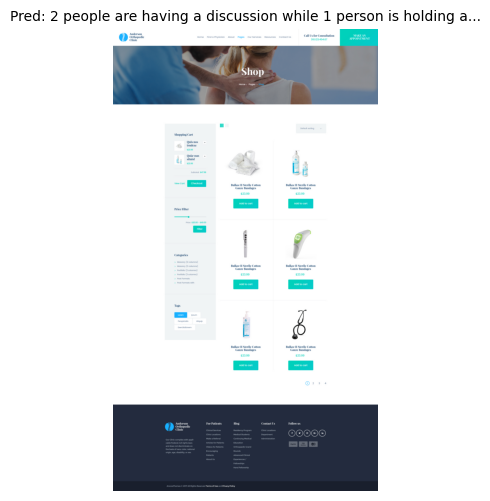

Ground Truth: This screenshot features a website, albeit in a blurry and small format, making it challenging to read. At the very top of the page, there is a white navigation bar. On the left side of the bar, a blue icon resembling a human vertebra is clearly visible, accompanied by the text "Anderson Orthopedic Clinic" in black font. Towards the right end of this bar, there are clickable selections for different webpages, though the text is too small to decipher. Adjacent to these selections, there is a mention of "Call for cancellation" beside a light blue square containing white text.

Below the navigation bar, there is a prominent photo displaying a Caucasian man, clad in blue scrubs. He has a brown beard and noticeably dirty fingernails. His hand is gently resting on the neck of a Caucasian woman who is wearing a white tank top and has blonde hair styled in a side ponytail. This interaction seems to be taking place in a medical office setting.

Further down the page, there is a se

In [ ]:

# ============================================================
# 7. Main Execution
# ============================================================

# 1. Build Datasets & Loaders (fresh extract)
vision_loader, audio_loader, raw_vision_data = build_eval_dataloaders(cfg)

# 2. Load the Aligned System
eval_model = load_full_model(cfg)

In [21]:
# 3. Run Metrics
evaluate_retrieval(eval_model, vision_loader, modality="vision", num_batches=20)
evaluate_retrieval(eval_model, audio_loader, modality="audio", num_batches=20)


Starting VISION retrieval eval...


  0%|          | 0/13 [00:00<?, ?it/s]

[VISION] Results on 100 samples:
  R@1: 0.0700
  R@5: 0.2900

Starting AUDIO retrieval eval...


  0%|          | 0/13 [00:00<?, ?it/s]

[AUDIO] Results on 100 samples:
  R@1: 0.0200
  R@5: 0.0500



--- Qualitative Inference Sample 5 ---


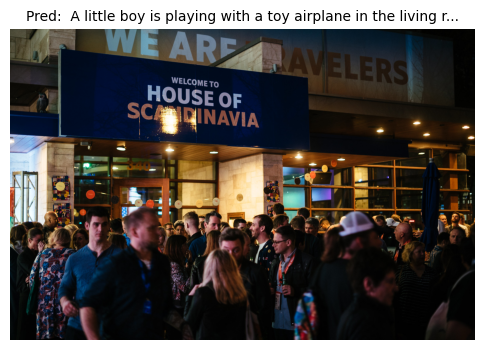

Ground Truth: In this night-time photograph, a diverse crowd congregates around the entrance of a building adorned with a prominent blue sign that reads, "Welcome to House of Scandinavia" in white and gold letters. The building itself stands out with a warm, golden hue, illuminated by lights above the entrance and the sign itself, providing the primary source of light in the otherwise dark scene. Above the main sign, additional text emblazoned on the building reads, "We are Travelers," with "We are" in white and "Travelers" in brown letters. The crowd, consisting predominantly of people in their 30s and 40s, features various individuals, including a man sporting a baseball hat and a ponytail. Some people appear to be entering the building while others are walking away, contributing to a lively, bustling atmosphere. The well-lit entrance and the activity around it suggest that this location could be a popular bar or nightlife venue.
Prediction:    A little boy is playing with a toy airp

In [23]:
# 4. Run Visual Check
if len(raw_vision_data) > 0:
    visualize_inference(eval_model, raw_vision_data)

In [9]:
# import torch
# from PIL import Image
# from vlmeval.smp import *
# from vlmeval.vlm.base import BaseModel
# from transformers import CLIPImageProcessor, WhisperProcessor, WhisperModel, CLIPVisionModel


In [10]:

# # ============================================================
# # 1. The VLMEvalKit Wrapper
# # ============================================================
# class EdgeGlassOmni(BaseModel):
#     """
#     Wrapper to make your AlignedModel compatible with VLMEvalKit.
#     Handles: Image/Audio Loading -> Feature Extraction -> Generation
#     """
#     def __init__(self, model_path="EdgeGlass-7B", **kwargs):
#         # 1. Load your system (Adapters + Qwen)
#         # We assume 'load_full_model' & 'Config' are available or imported
#         # from your previous script (02_eval_inference.py).
        
#         # Re-create config locally if needed
#         from dataclasses import dataclass
#         from pathlib import Path
#         @dataclass
#         class Config:
#             ckpt_path: Path = Path("./runs_perceiver_mrl_qwen/multimodal_adapter_poc.pt")
#             vision_model_name: str = "openai/clip-vit-base-patch32"
#             audio_model_name: str = "openai/whisper-base"
#             llm_model_name: str = "Qwen/Qwen2.5-7B-Instruct"
#             perceiver_dim: int = 512
#             num_latents: int = 64
#             num_perceiver_layers: int = 2
#             num_attn_heads: int = 8
#             mlp_ratio: float = 4.0
#             encoder_dim_vision: int = 768 
#             encoder_dim_audio: int = 512 
#             llm_hidden_size: int = 3584
            
#         self.cfg = Config()
#         print(f"Loading EdgeGlassOmni from {self.cfg.ckpt_path}...")
        
#         # Use your existing loader function
#         self.model = load_full_model(self.cfg) 
#         self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
#         # Load Processors for feature extraction
#         self.clip_proc = CLIPImageProcessor.from_pretrained(self.cfg.vision_model_name)
#         self.whisper_proc = WhisperProcessor.from_pretrained(self.cfg.audio_model_name)
        
#         # We need separate access to encoders for raw features
#         # (Ideally these should be part of your AlignedModel, but we load them here for safety)
#         self.clip_enc = CLIPVisionModel.from_pretrained(self.cfg.vision_model_name).to(self.device).eval()
#         self.whisper_enc = WhisperModel.from_pretrained(self.cfg.audio_model_name).encoder.to(self.device).eval()

#     def generate_inner(self, message, dataset=None):
#         """
#         VLMEvalKit calls this. 'message' is a list of dicts:
#         [ {'type': 'image', 'value': '/path/to/img.jpg'}, {'type': 'text', 'value': 'Question...'} ]
#         """
#         prompt = ""
#         image_path = None
#         audio_path = None # VLMEvalKit might not pass this standardly yet, but we can parse it
        
#         # 1. Parse Message
#         for msg in message:
#             if msg['type'] == 'text':
#                 prompt += msg['value']
#             elif msg['type'] == 'image':
#                 image_path = msg['value']
#             elif msg['type'] == 'audio': # Future-proofing for OmniBench
#                 audio_path = msg['value']
                
#         # 2. Handle Modalities
#         if image_path:
#             return self.generate_vision(image_path, prompt)
#         elif audio_path:
#             return self.generate_audio(audio_path, prompt)
#         else:
#             # Pure text (fallback)
#             return "Error: No modality found."

#     def generate_vision(self, img_path, prompt):
#         # Load Image
#         image = Image.open(img_path).convert('RGB')
        
#         # Preprocess -> CLIP Features
#         inputs = self.clip_proc(images=image, return_tensors="pt").to(self.device)
#         with torch.no_grad():
#             # (1, T, D)
#             feats = self.clip_enc(**inputs).last_hidden_state
            
#         # Generate via your AlignedModel
#         # Ensure prompt formatting matches Qwen-Instruct
#         full_prompt = f"User: <image>\n{prompt}\nAssistant:"
        
#         response = self.model.generate(
#             modality_feats=feats,
#             modality_type="vision",
#             prompt_text=full_prompt,
#             max_new_tokens=200
#         )
#         return response

#     def generate_audio(self, audio_path, prompt):
#         # Load Audio
#         import librosa
#         wav, sr = librosa.load(audio_path, sr=16000)
        
#         # Preprocess -> Whisper Features
#         inputs = self.whisper_proc(wav, sampling_rate=16000, return_tensors="pt").to(self.device)
#         with torch.no_grad():
#             # (1, T, D)
#             feats = self.whisper_enc(inputs.input_features).last_hidden_state
            
#         full_prompt = f"User: <audio>\n{prompt}\nAssistant:"
        
#         response = self.model.generate(
#             modality_feats=feats,
#             modality_type="audio",
#             prompt_text=full_prompt,
#             max_new_tokens=200
#         )
#         return response

In [11]:
# from vlmeval.utils import dataset_URLs, dataset_md5

# # 1. Register your model (if not using the config file method)
# model = EdgeGlassOmni()

# # 2. Select Benchmark (e.g., MMBench_DEV_EN for quick test)
# # VLMEvalKit handles downloading and metric calc automatically
# dataset_name = 'MMBench_DEV_EN' 

# # 3. Run Evaluation
# from vlmeval.eval import evaluate_benchmark

# print(f"🚀 Running {dataset_name} on EdgeGlass-7B...")
# # This function manages the loop, batching, and scoring
# results = evaluate_benchmark(
#     model=model, 
#     dataset_name=dataset_name,
#     batch_size=4,  # Adjust based on GPU VRAM
#     work_dir='./work_dirs/edge_glass_eval'
# )

# print("Final Score:", results)

In [12]:
# class OmniAudioEval:
#     """
#     A 'VLMEval-style' evaluator for Audio benchmarks.
#     """
#     def __init__(self, model):
#         self.model = model

#     def eval_librispeech(self, num_samples=100):
#         print("\n--- 🎤 LibriSpeech ASR (WER) ---")
#         # Re-using the logic from Part 11 but wrapping it nicely
#         score = benchmark_librispeech_asr(self.model.model, num_samples)
#         return {"LibriSpeech_WER": score}

#     def eval_esc50(self):
#         print("\n--- 🔔 ESC-50 Classification ---")
#         score = benchmark_esc50_zeroshot(self.model.model)
#         return {"ESC50_Acc": score}

# # Usage
# audio_evaluator = OmniAudioEval(model) # Pass the wrapper we created above
# res_libri = audio_evaluator.eval_librispeech(num_samples=50)
# res_esc = audio_evaluator.eval_esc50()

# print("\n--- 🏆 Final Omni Benchmark Report ---")
# print(res_libri)
# print(res_esc)

In [13]:
# 

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
import librosa
import io
from PIL import Image
from tqdm.auto import tqdm
from torchmetrics.text import WordErrorRate, BLEUScore
import numpy as np
import requests
from io import BytesIO
from transformers import CLIPImageProcessor, CLIPVisionModel, WhisperProcessor, WhisperModel

# ============================================================
# 1. Benchmark Configuration
# ============================================================
# We assume 'eval_model', 'device', and 'cfg' are already loaded in memory 
# from the previous notebook (02_eval_inference.ipynb).
print(f"🚀 Starting Benchmark Suite on device: {device}")

# ============================================================
# 2. Audio Benchmarks (ASR & Classification)
# ============================================================

def benchmark_librispeech_asr(model, num_samples=100):
    """
    1️⃣ LibriSpeech ASR (High Priority)
    Metric: WER (Word Error Rate)
    FIX: Uses .decode(False) and robust error handling
    """
    print("\n--- 🎤 Benchmarking LibriSpeech ASR (WER) ---")
    
    # Load with decode=False to avoid torchcodec errors
    ds = load_dataset("openslr/librispeech_asr", "clean", split="test", streaming=True)
    ds = ds.decode(False)
    
    wer_metric = WordErrorRate().to("cpu")
    processor = WhisperProcessor.from_pretrained(cfg.audio_model_name)
    
    predictions = []
    references = []
    
    count = 0
    model.eval()
    
    # Use a fresh encoder for feature extraction
    whisper_enc = WhisperModel.from_pretrained(cfg.audio_model_name).encoder.to(device)
    
    for ex in tqdm(ds, total=num_samples, desc="LibriSpeech Inference"):
        if count >= num_samples: break
        
        try:
            # 1. Manually Decode
            audio_bytes = ex["audio"]["bytes"]
            text = ex["text"]
            audio, sr = librosa.load(io.BytesIO(audio_bytes), sr=16000)
            
            # 2. Encode Features
            inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
            input_features = inputs.input_features.to(device)
            
            with torch.no_grad():
                enc_out = whisper_enc(input_features).last_hidden_state # (1, T, D)
            
            # 3. Generate
            # Wrapper handles dtype casting internally for generation
            feats = enc_out.cpu() 
            prompt = "User: Transcribe the speech in this audio clip verbatim.\nAssistant:"
            pred_text = model.generate(feats, "audio", prompt, max_new_tokens=100)
            
            # 4. Normalize
            pred_norm = pred_text.lower().strip().replace(".", "").replace(",", "").replace("?", "")
            ref_norm = text.lower().strip().replace(".", "").replace(",", "").replace("?", "")
            
            predictions.append(pred_norm)
            references.append(ref_norm)
            count += 1
            
        except Exception as e:
            continue

    if len(predictions) > 0:
        score = wer_metric(predictions, references)
        print(f"📉 LibriSpeech WER: {score.item():.4f} (Lower is better)")
        print(f"   Ref:  {references[0]}")
        print(f"   Pred: {predictions[0]}")
        return score.item()
    return 1.0

def benchmark_esc50_zeroshot(model):
    """
    2️⃣ ESC-50 Environmental Sound Classification
    FIX: Casts embeddings to float32 for similarity calculation
    """
    print("\n--- 🔔 Benchmarking ESC-50 (Zero-Shot Accuracy) ---")
    
    esc50_classes = [
        'dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow',
        'rain', 'sea_waves', 'crackling_fire', 'crickets', 'chirping_birds', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm',
        'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'footsteps', 'laughing', 'brushing_teeth', 'snoring', 'drinking_sipping',
        'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking',
        'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw'
    ]
    
    # 1. Embed Class Names
    prompts = [f"The sound of {c}." for c in esc50_classes]
    model.eval()
    with torch.no_grad():
        # Get BFloat16 embeddings from Qwen, CAST TO FLOAT32
        class_embs = model.encode_text_raw(prompts).float() 
        class_embs = F.normalize(class_embs, dim=-1)
    
    # 2. Load Dataset
    try:
        ds = load_dataset("ashraq/esc50", split="train", streaming=True).decode(False)
    except:
        print("Skipping ESC-50 (load error).")
        return 0.0

    correct = 0
    total = 0
    processor = WhisperProcessor.from_pretrained(cfg.audio_model_name)
    whisper_enc = WhisperModel.from_pretrained(cfg.audio_model_name).encoder.to(device)
    
    for ex in tqdm(ds, total=200, desc="ESC-50 Inference"):
        if total >= 200: break
        try:
            audio_bytes = ex["audio"]["bytes"]
            category = ex["category"]
            
            audio, _ = librosa.load(io.BytesIO(audio_bytes), sr=16000)
            inputs = processor(audio, sampling_rate=16000, return_tensors="pt").to(device)
            
            with torch.no_grad():
                raw_feats = whisper_enc(inputs.input_features).last_hidden_state.cpu()
                mask = torch.ones(1, raw_feats.shape[1], dtype=torch.bool)
                
                # Get Float32 embeddings from Adapter, CAST TO FLOAT32 explicitly
                audio_emb = model.encode_audio_features(raw_feats.to(device), mask.to(device))
                audio_emb = audio_emb.float()
                audio_emb = F.normalize(audio_emb, dim=-1)
            
            # Calculate Similarity (Now both are Float32)
            sims = audio_emb @ class_embs.T
            pred_idx = sims.argmax().item()
            pred_class = esc50_classes[pred_idx]
            
            if pred_class == category:
                correct += 1
            total += 1
        except:
            continue
            
    if total > 0:
        acc = correct / total
        print(f"🏆 ESC-50 Zero-Shot Accuracy: {acc*100:.2f}%")
        return acc
    return 0.0

# ============================================================
# 3. Visual Benchmarks (Captioning & Retrieval)
# ============================================================

def benchmark_coco_captioning(model, num_samples=100):
    """
    3️⃣ COCO Captioning Proxy
    """
    print("\n--- 🖼️ Benchmarking COCO Captioning (Qualitative) ---")
    ds = load_dataset("allenai/pixmo-cap", split="train", streaming=True)
    preds_list = []
    clip_proc = CLIPImageProcessor.from_pretrained(cfg.vision_model_name)
    clip_enc = CLIPVisionModel.from_pretrained(cfg.vision_model_name).to(device)
    
    count = 0
    for ex in tqdm(ds, total=num_samples, desc="Captioning"):
        if count >= num_samples: break
        try:
            url = ex.get("image_url")
            if not url: continue
            resp = requests.get(url, timeout=1)
            img = Image.open(io.BytesIO(resp.content)).convert("RGB")
            
            inputs = clip_proc(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                raw_feats = clip_enc(**inputs).last_hidden_state.cpu()
                
            prompt = "User: Provide a detailed caption for this image.\nAssistant:"
            gen_text = model.generate(raw_feats, "vision", prompt, max_new_tokens=60)
            
            preds_list.append(gen_text)
            count += 1
        except:
            continue
    if preds_list:
        print(f"   Example Pred: {preds_list[0]}")
    return preds_list

def benchmark_coco_retrieval(model, num_samples=200):
    """
    4️⃣ COCO Retrieval Proxy
    FIX: Casts embeddings to float32 for similarity calculation
    """
    print("\n--- 🔍 Benchmarking Retrieval (Recall@K) ---")
    
    ds = load_dataset("allenai/pixmo-cap", split="train", streaming=True)
    
    imgs_feats = []
    texts_list = []
    
    clip_proc = CLIPImageProcessor.from_pretrained(cfg.vision_model_name)
    clip_enc = CLIPVisionModel.from_pretrained(cfg.vision_model_name).to(device)
    
    count = 0
    for ex in tqdm(ds, total=num_samples, desc="Encoding Pairs"):
        if count >= num_samples: break
        try:
            url = ex.get("image_url")
            caption = ex.get("caption")
            if not url or not caption: continue
            
            resp = requests.get(url, timeout=1)
            img = Image.open(io.BytesIO(resp.content)).convert("RGB")
            
            inputs = clip_proc(images=img, return_tensors="pt").to(device)
            with torch.no_grad():
                raw_v = clip_enc(**inputs).last_hidden_state
                mask = torch.ones(1, raw_v.shape[1], dtype=torch.bool, device=device)
                
                # Encode and CAST TO FLOAT32
                v_emb = model.encode_image_features(raw_v.to(device), mask)
                v_emb = v_emb.float()
                v_emb = F.normalize(v_emb, dim=-1)
                
            imgs_feats.append(v_emb.cpu())
            texts_list.append(caption)
            count += 1
        except:
            continue
            
    if not imgs_feats:
        print("No samples processed.")
        return

    # Encode Texts
    model.eval()
    with torch.no_grad():
        t_embs = []
        batch_size = 32
        for i in range(0, len(texts_list), batch_size):
            batch_txt = texts_list[i:i+batch_size]
            # Get BF16 from Qwen, CAST TO FLOAT32
            e = model.encode_text_raw(batch_txt).float() 
            t_embs.append(e.cpu())
        t_embs = torch.cat(t_embs, dim=0)
        t_embs = F.normalize(t_embs, dim=-1)
        
    img_tensor = torch.cat(imgs_feats, dim=0) # (N, D) float32
    
    # Calculate Similarity (Both are float32 now)
    sims = img_tensor @ t_embs.T 
    n = sims.shape[0]
    targets = torch.arange(n)
    
    preds = sims.argsort(dim=1, descending=True)
    i2t_r1 = (preds[:, 0] == targets).float().mean().item()
    i2t_r5 = (preds[:, :5] == targets.unsqueeze(1)).any(dim=1).float().mean().item()
    
    print(f"🏆 Retrieval Results (N={n}):")
    print(f"   Image->Text R@1: {i2t_r1:.4f}")
    print(f"   Image->Text R@5: {i2t_r5:.4f}")

# ============================================================
# 4. OmniBench (Tri-Modal Proxy)
# ============================================================
def benchmark_omnibench_proxy(model):
    print("\n--- 🧩 Benchmarking OmniBench (Proxy Qualitative Test) ---")
    prompt = "User: Look at this image and listen to this sound. Does the sound match the image?\nAssistant:"
    
    try:
        # Load Image
        img_url = "https://coco.cs.utexas.edu/content/images/val2017/000000000139.jpg"
        img = Image.open(io.BytesIO(requests.get(img_url, timeout=5).content)).convert("RGB")
        
        # Load Audio (LibriSpeech)
        ds = load_dataset("openslr/librispeech_asr", "clean", split="test", streaming=True).decode(False)
        audio_bytes = next(iter(ds))["audio"]["bytes"]
        audio, _ = librosa.load(io.BytesIO(audio_bytes), sr=16000)

        # Encoders
        clip_proc = CLIPImageProcessor.from_pretrained(cfg.vision_model_name)
        clip_enc = CLIPVisionModel.from_pretrained(cfg.vision_model_name).to(device)
        whisper_proc = WhisperProcessor.from_pretrained(cfg.audio_model_name)
        whisper_enc = WhisperModel.from_pretrained(cfg.audio_model_name).encoder.to(device)

        # Features
        v_in = clip_proc(images=img, return_tensors="pt").to(device)
        a_in = whisper_proc(audio, sampling_rate=16000, return_tensors="pt").to(device)
        
        with torch.no_grad():
            v_feats = clip_enc(**v_in).last_hidden_state
            a_feats = whisper_enc(a_in.input_features).last_hidden_state

            # Project (Manual logic from generate function)
            adapter_dev = next(model.vision_adapter.parameters()).device
            qwen_dev = model.qwen_model.model.embed_tokens.weight.device
            qwen_dtype = model.qwen_model.model.embed_tokens.weight.dtype

            v_toks = model.vision_adapter(v_feats.to(adapter_dev))
            a_toks = model.audio_adapter(a_feats.to(adapter_dev))
            
            v_mask = torch.ones(1, v_toks.shape[1], dtype=torch.bool, device=adapter_dev)
            a_mask = torch.ones(1, a_toks.shape[1], dtype=torch.bool, device=adapter_dev)
            
            v_proj = model.projector(model.perceiver(v_toks, v_mask)).to(device=qwen_dev, dtype=qwen_dtype)
            a_proj = model.projector(model.perceiver(a_toks, a_mask)).to(device=qwen_dev, dtype=qwen_dtype)
            
            txt_in = model.qwen_tokenizer(prompt, return_tensors="pt").to(qwen_dev)
            t_emb = model.qwen_model.get_input_embeddings()(txt_in.input_ids)
            
            combined = torch.cat([v_proj, a_proj, t_emb], dim=1)
            
            out = model.qwen_model.generate(
                inputs_embeds=combined, max_new_tokens=50, do_sample=True, 
                pad_token_id=model.qwen_tokenizer.eos_token_id
            )
            res = model.qwen_tokenizer.batch_decode(out, skip_special_tokens=True)[0]
            print(f"\nOmni Result: {res}")
            
    except Exception as e:
        print(f"OmniBench failed: {e}")

# ============================================================
# 5. Main Execution
# ============================================================
if 'eval_model' in globals():
    benchmark_librispeech_asr(eval_model, num_samples=10)
    benchmark_esc50_zeroshot(eval_model)
    benchmark_coco_retrieval(eval_model, num_samples=50)
    benchmark_coco_captioning(eval_model, num_samples=5)
    benchmark_omnibench_proxy(eval_model)

🚀 Starting Benchmark Suite on device: cuda

--- 🎤 Benchmarking LibriSpeech ASR (WER) ---


Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

LibriSpeech Inference:   0%|          | 0/10 [00:00<?, ?it/s]

📉 LibriSpeech WER: 3.1793 (Lower is better)
   Ref:  concord returned to its place amidst the tents
   Pred: i'm sorry but i don't have access to the specific audio clip you're referring to in order to transcribe the speech from an audio clip i would need you to provide either a link to the audio or a direct recording of it once i have access to the audio i can assist you with transcribing it verbatim if you could provide the necessary audio content i'd be happy to help with the transcription otherwise if you have any other questions or need assistance

--- 🔔 Benchmarking ESC-50 (Zero-Shot Accuracy) ---


Repo card metadata block was not found. Setting CardData to empty.


ESC-50 Inference:   0%|          | 0/200 [00:00<?, ?it/s]

🏆 ESC-50 Zero-Shot Accuracy: 3.00%

--- 🔍 Benchmarking Retrieval (Recall@K) ---


Encoding Pairs:   0%|          | 0/50 [00:00<?, ?it/s]

🏆 Retrieval Results (N=50):
   Image->Text R@1: 0.0800
   Image->Text R@5: 0.5200

--- 🖼️ Benchmarking COCO Captioning (Qualitative) ---


Captioning:   0%|          | 0/5 [00:00<?, ?it/s]

   Example Pred:  I apologize, but I don't see any image attached to your request. Could you please provide a description or upload an image so I can help you create an appropriate caption? I'd be happy to assist once I have more details about what the image contains. Whether it's a photo, drawing,

--- 🧩 Benchmarking OmniBench (Proxy Qualitative Test) ---
OmniBench failed: HTTPSConnectionPool(host='coco.cs.utexas.edu', port=443): Max retries exceeded with url: /content/images/val2017/000000000139.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ffba0e36720>: Failed to resolve 'coco.cs.utexas.edu' ([Errno -2] Name or service not known)"))
